<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/%EA%B8%88%EC%9C%B5%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%EC%BF%A1%EB%B6%81/10%EC%9E%A5_%EA%B8%88%EC%9C%B5%EC%97%90%EC%84%9C%EC%9D%98_%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [4, 2]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
from fastai import *
from fastai.tabular import *

In [4]:
from fastai.tabular.all import *

In [5]:
from fastai.tabular.data import TabularPandas

In [6]:
import pandas as pd

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from fastai import *
from fastai.tabular import *
from sklearn import metrics
import numpy as np
import os
import random
import torch

def performance_evaluation_report(model, show_plot=False, labels=None, show_pr_curve=False):

    preds_valid, y_test = model.get_preds(ds_type=DatasetType.Valid)
    y_pred = preds_valid.argmax(dim=-1)
    y_pred_prob = preds_valid.numpy()[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = metrics.precision_score(y_test, y_pred),
    recall = metrics.recall_score(y_test, y_pred),

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision_vec, recall_vec, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall_vec, precision_vec)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall_vec, precision_vec,
                       label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].plot(recall, precision, 'ro',
                       markersize=8, label='Decision Point')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats


def create_input_data(series, n_lags=1, n_leads=1):

    X = []
    y = []

    for step in range(len(series) - n_lags - n_leads + 1):

        end_step = step + n_lags
        forward_end = end_step + n_leads
        X.append(series[step:end_step])
        y.append(series[end_step:forward_end])

    return np.array(X), np.array(y)

def custom_set_seed(seed):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [8]:
import yfinance as yf
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, 
                              DataLoader, Subset)

In [9]:
from sklearn.metrics import mean_squared_error

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.12.1+cu113


In [128]:
from sklearn.preprocessing import MinMaxScaler

# 테이블 데이터를 사용한 딥러닝

In [71]:
df = pd.read_csv('/content/credit_card_default.csv', index_col=0, na_values='')

In [72]:
df.head()

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,...,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,Unknown,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   30000 non-null  int64  
 1   sex                         29850 non-null  object 
 2   education                   29850 non-null  object 
 3   marriage                    29850 non-null  object 
 4   age                         29850 non-null  float64
 5   payment_status_sep          30000 non-null  object 
 6   payment_status_aug          30000 non-null  object 
 7   payment_status_jul          30000 non-null  object 
 8   payment_status_jun          30000 non-null  object 
 9   payment_status_may          30000 non-null  object 
 10  payment_status_apr          30000 non-null  object 
 11  bill_statement_sep          30000 non-null  int64  
 12  bill_statement_aug          30000 non-null  int64  
 13  bill_statement_jul          300

In [74]:
# 종속 변수와 수치/범주 특징을 식별
DEP_VAR = 'default_payment_next_month'

num_features = list(df.select_dtypes('number').columns)
num_features.remove(DEP_VAR)
cat_features = list(df.select_dtypes('object').columns)

In [75]:
print(num_features)
print(cat_features)

['limit_bal', 'age', 'bill_statement_sep', 'bill_statement_aug', 'bill_statement_jul', 'bill_statement_jun', 'bill_statement_may', 'bill_statement_apr', 'previous_payment_sep', 'previous_payment_aug', 'previous_payment_jul', 'previous_payment_jun', 'previous_payment_may', 'previous_payment_apr']
['sex', 'education', 'marriage', 'payment_status_sep', 'payment_status_aug', 'payment_status_jul', 'payment_status_jun', 'payment_status_may', 'payment_status_apr']


In [76]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

data = TabularPandas(df, 
                     cat_names=cat_features,
                     cont_names=num_features, 
                     procs=[Categorify, FillMissing, Normalize],
                     y_names=DEP_VAR,
                     splits=splits)

In [77]:
data = data.dataloaders(bs=64)

In [78]:
data.show_batch()


,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,Female,Graduate school,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,139999.999562,40.000000,67370.999582,69026.998975,56174.999906,57665.999539,59603.999375,62480.000189,3100.000114,3887.999948,2799.999996,2800.000020,3800.000004,2999.999941,0.0
1,Male,Graduate school,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,50000.002925,25.000000,50401.000008,46275.000047,0.001730,0.000248,-0.000567,-0.001583,5000.000026,0.000128,-0.000127,0.000072,0.000129,-0.000099,0.0
2,Male,Graduate school,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,80000.003736,36.000000,68930.999973,67705.999428,67017.000903,65158.999915,64151.999535,65208.000269,2500.000122,3000.000012,2244.000094,2477.999892,4800.000000,-0.000099,0.0
3,Female,University,Single,Payment delayed 1 month,Payment delayed 3 months,Payment delayed 2 months,Unknown,Unknown,Unknown,False,80000.003736,34.000000,84054.001056,82193.999218,78715.000102,26680.999713,-0.000567,-0.001583,3.000246,4.999839,1074.999918,0.000072,0.000129,-0.000099,1.0
4,Male,University,Single,Payment delayed 2 months,Payment delayed 2 months,Payment delayed 2 months,Payment delayed 2 months,Payment delayed 2 months,Payment delayed 2 months,False,139999.999562,26.000001,119424.000561,116014.001525,133566.999626,129953.003558,136283.001028,139961.000063,0.000030,19500.000518,-0.000127,9999.999886,6000.000017,5000.000006,1.0
5,Female,High school,Single,Payment delayed 1 month,Payment delayed 2 months,Unknown,Unknown,Unknown,Unknown,False,419999.994897,25.000000,72873.999345,71034.999593,57503.000182,56467.000320,53994.999619,55304.000037,0.000030,2000.000168,1892.000090,1979.000062,2225.999994,23011.000338,1.0
6,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,180000.000000,38.000000,9705.001373,2169.999573,0.001730,0.000248,-0.000567,-0.001583,999.999767,0.000128,-0.000127,0.000072,0.000129,-0.000099,0.0
7,Female,University,Married,Payment delayed 1 month,Unknown,Payed duly,Unknown,Unknown,Unknown,False,99999.999125,36.000000,-0.001166,0.000129,19927.999207,23254.999690,23967.999522,24530.999615,0.000030,19928.000600,3999.999934,1099.999934,1100.000019,1399.999901,0.0
8,Male,Graduate school,Married,Payment delayed 1 month,Payment delayed 2 months,Unknown,Unknown,Unknown,Unknown,False,50000.002925,49.000000,27231.000182,26499.999438,27532.999211,28569.000384,28900.999698,31094.999778,0.000030,1764.000130,3399.999965,1099.999934,2659.999948,-0.000099,1.0
9,Female,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,359999.993275,34.000000,277568.992451,246379.996493,236138.994899,241056.002876,246296.994331,246071.999617,10499.999766,8499.999945,8749.999890,9199.999901,9800.000125,8699.999962,0.0


In [87]:
learn = tabular_learner(data,
                        layers=[1000,500], 
                        metrics=[Recall(), 
                                 FBeta(beta=1),
                                 FBeta(beta=5)])

In [82]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3): Embedding(11, 6)
    (4): Embedding(11, 6)
    (5): Embedding(11, 6)
    (6): Embedding(11, 6)
    (7): Embedding(10, 6)
    (8): Embedding(10, 6)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=63, out_features=1000, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=1000, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=500, out_features=1, bias=True)
    )
  )
)

SuggestedLRs(valley=4.365158383734524e-05)

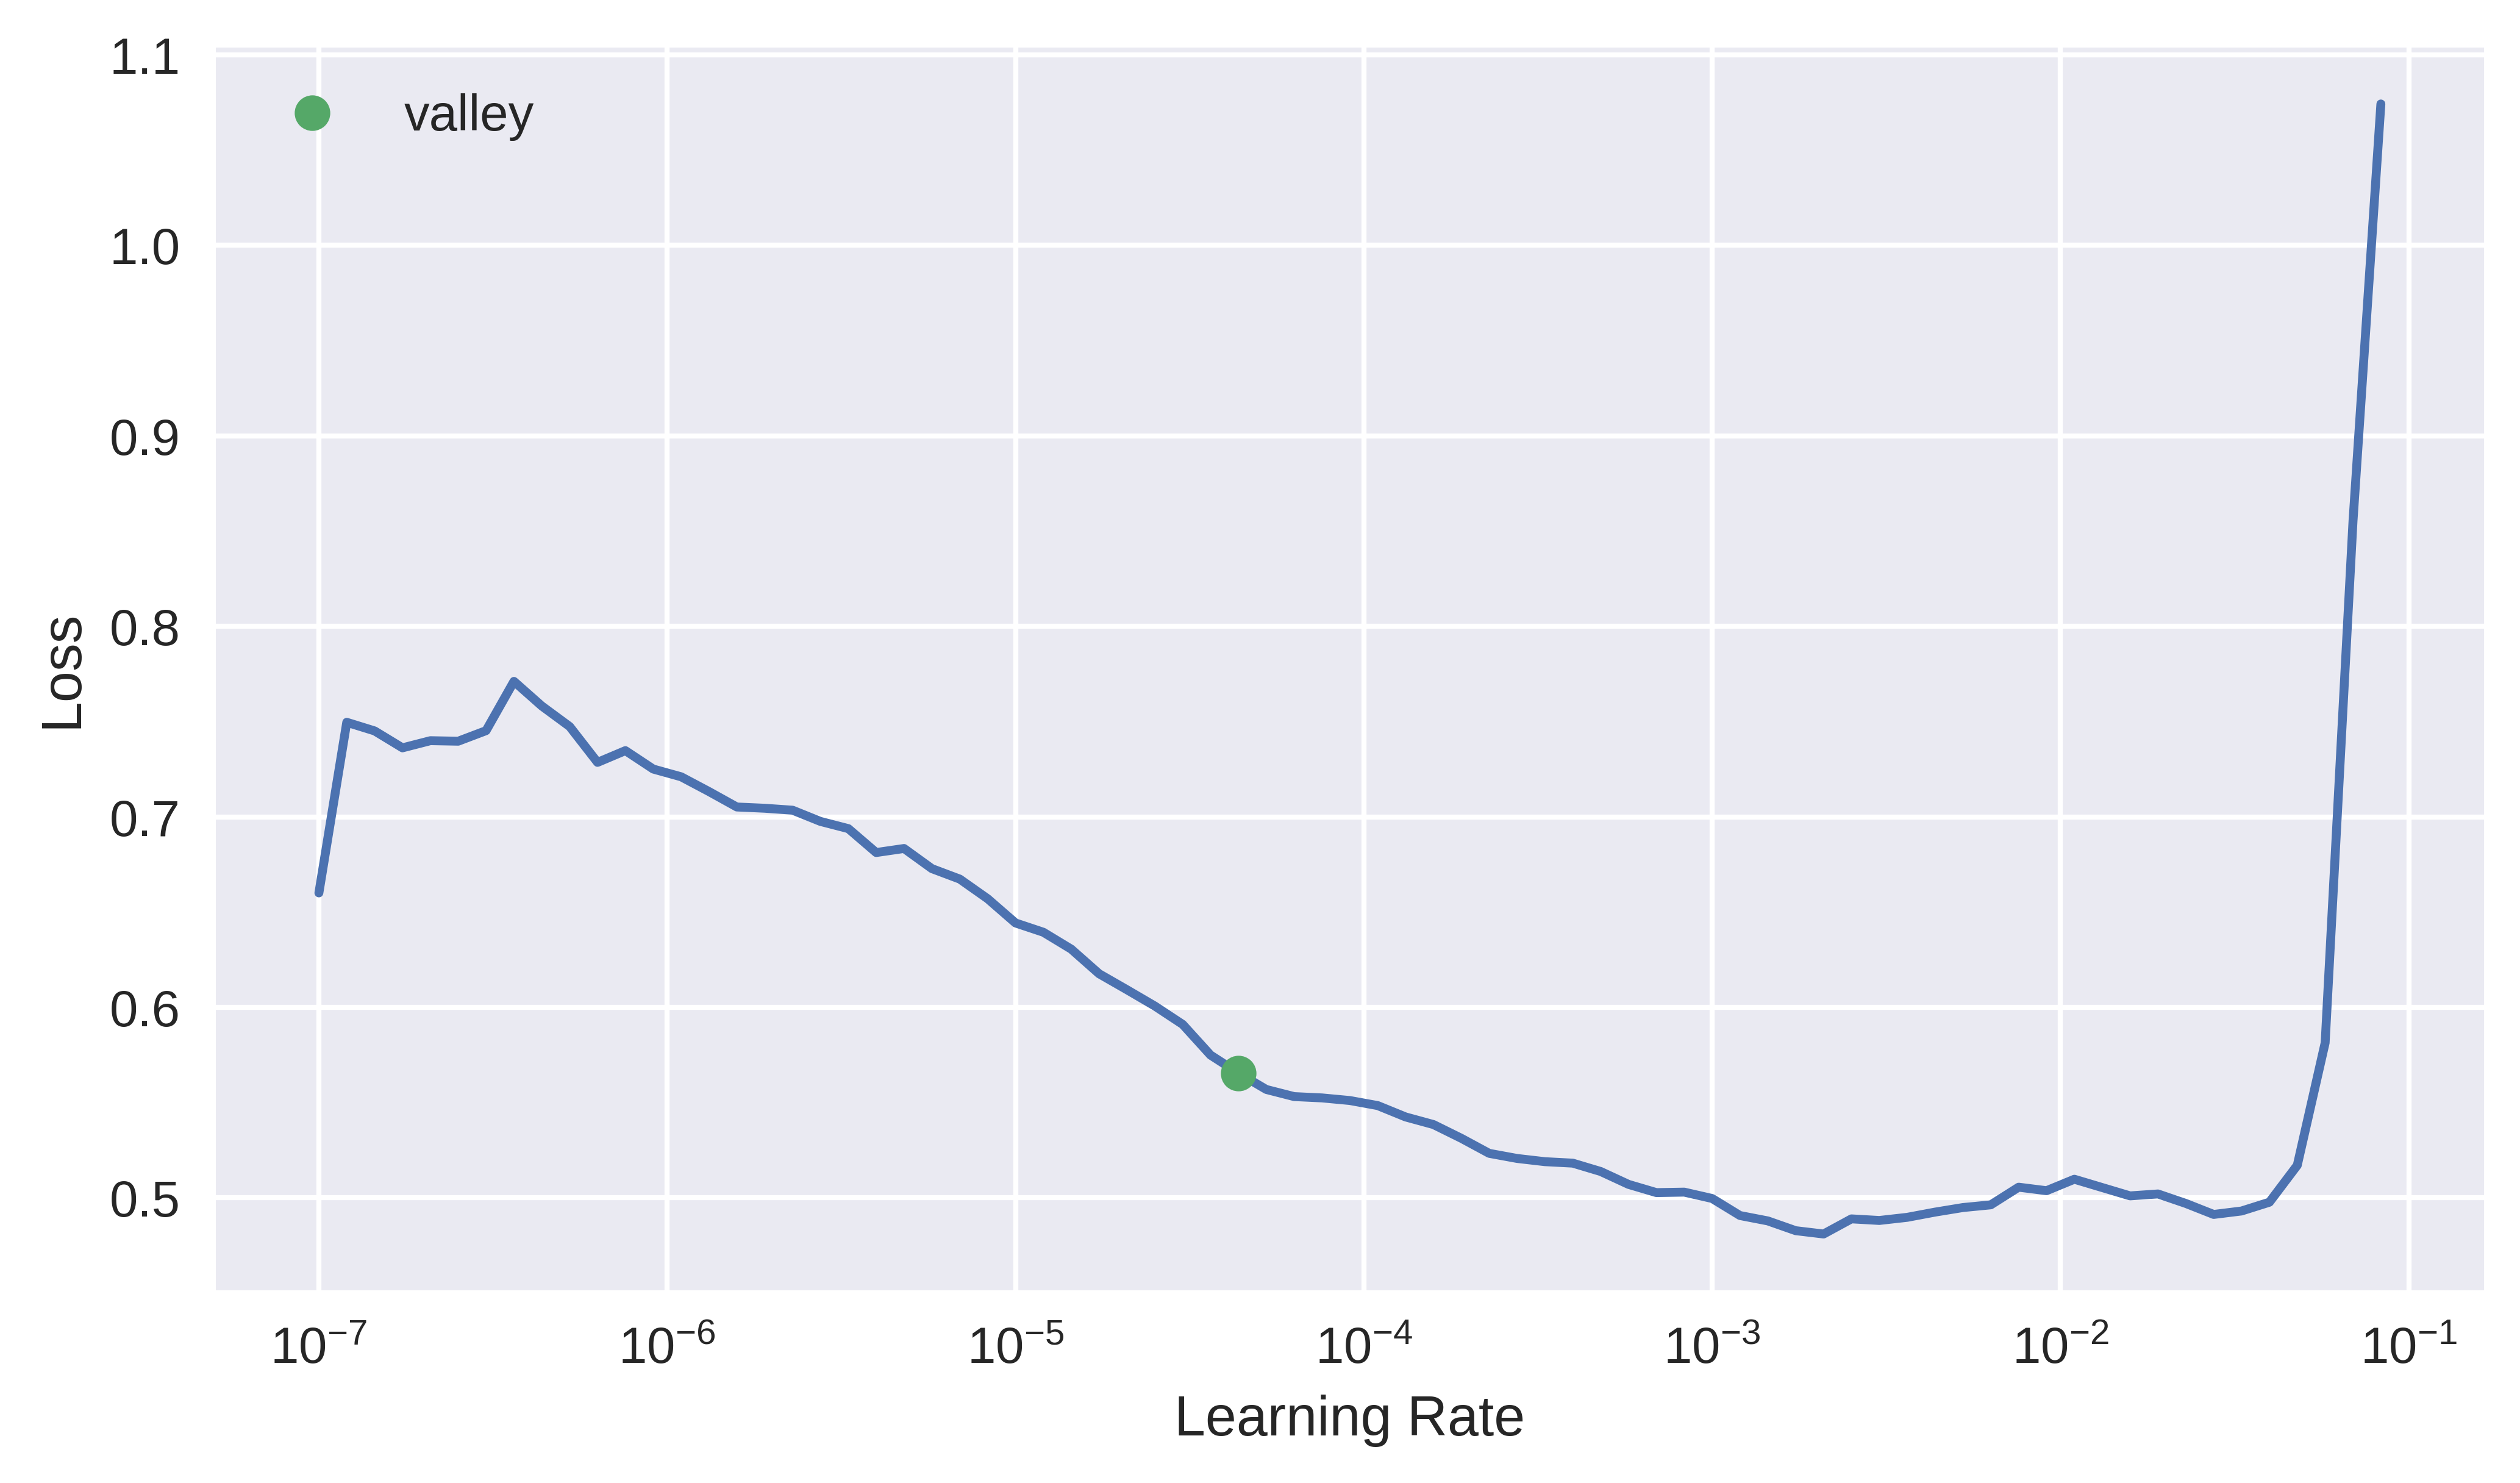

In [84]:
learn.lr_find()

In [88]:
learn.fit_one_cycle(n_epoch=25,
                    lr_max=1e-6,
                    wd=0.2)

epoch,train_loss,valid_loss,recall_score,fbeta_score,fbeta_score,time
0,0.729163,0.790182,0.000000,0.000000,0.000000,00:03
1,0.482032,0.378274,0.000000,0.000000,0.000000,00:03
2,0.325708,0.313175,0.000000,0.000000,0.000000,00:03
3,0.258738,0.252849,0.000000,0.000000,0.000000,00:03
4,0.246183,0.253389,0.000000,0.000000,0.000000,00:03
5,0.238286,0.241401,0.000000,0.000000,0.000000,00:03
6,0.233246,0.234195,0.000000,0.000000,0.000000,00:03
7,0.231989,0.231779,0.000000,0.000000,0.000000,00:03
8,0.235854,0.233238,0.000000,0.000000,0.000000,00:03
9,0.214173,0.227084,0.000000,0.000000,0.000000,00:03


# 시계열 예측을 위한 다층 퍼셉트론

In [30]:
TICKER = 'ANF'
START_DATE = '2012-01-02'
END_DATE = '2021-12-31'
N_LAGS = 3

In [31]:
VALID_SIZE = 12
BATCH_SIZE = 5
N_EPOCHS = 5000

In [32]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('M').last()
prices = df['Adj Close'].values

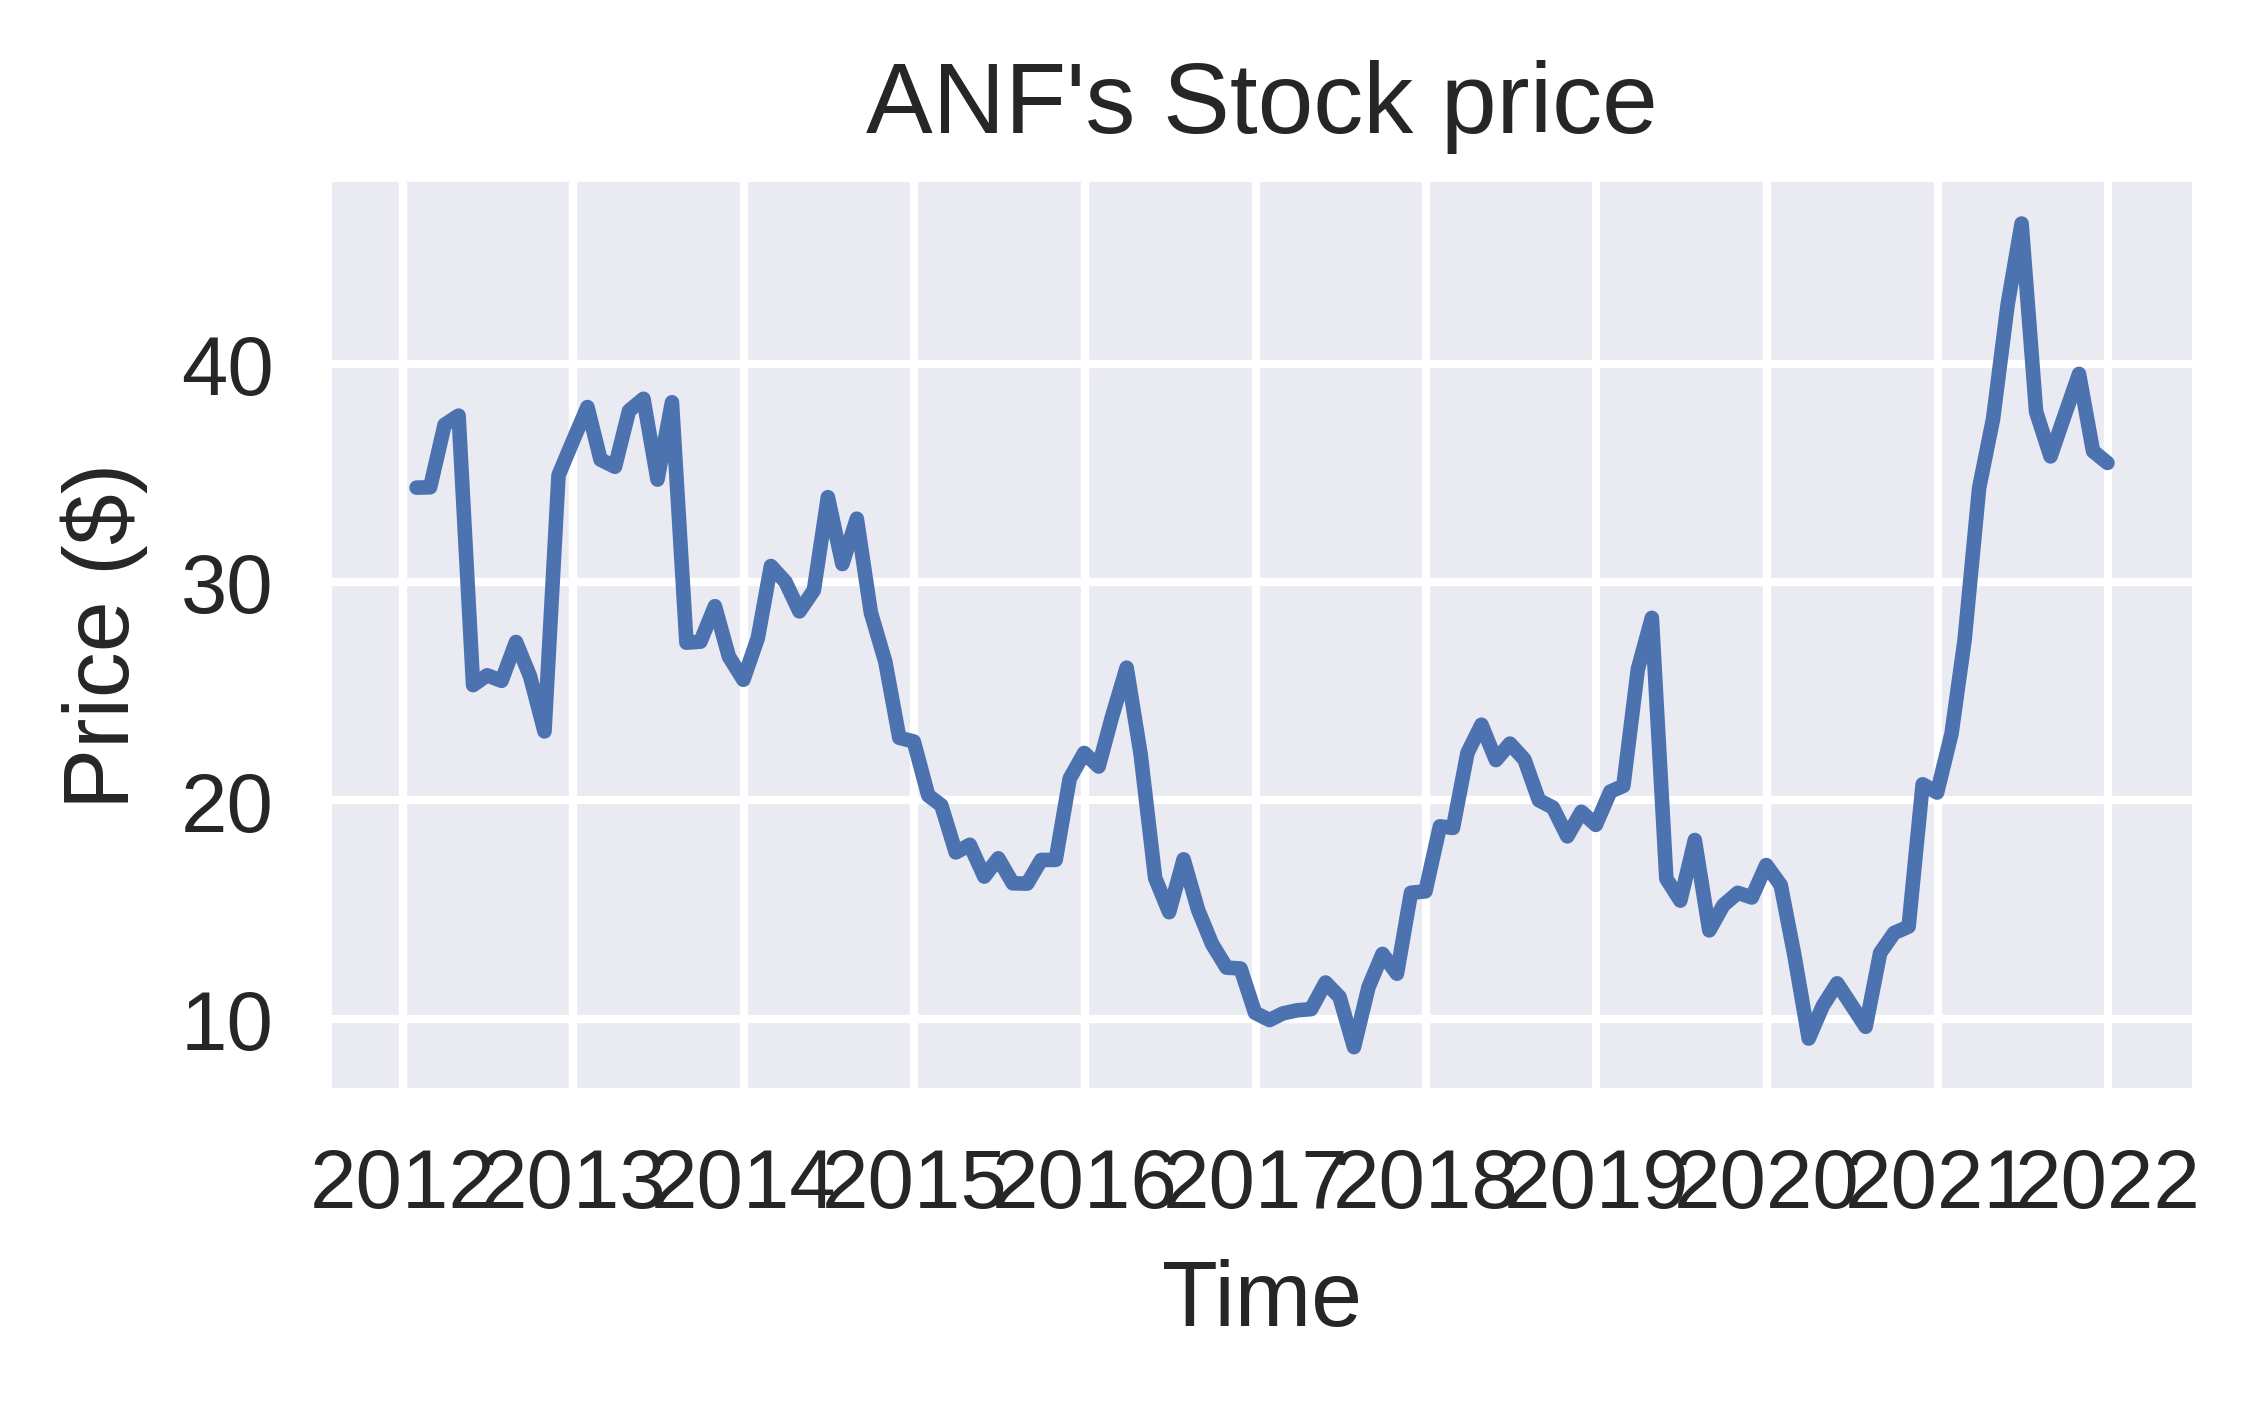

In [33]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

In [34]:
# MLP용 데이터 셋
def create_input_data(series, n_lags=1):

    X, y = [], []

    for step in range(len(series) - n_lags):

        end_step = step + n_lags
        X.append(series[step:end_step])
        y.append(series[end_step])
        
    return np.array(X), np.array(y)

In [35]:
X, y = create_input_data(prices, N_LAGS)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

In [36]:
valid_ind = len(X) - VALID_SIZE

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

In [37]:
next(iter(train_loader))[0]

tensor([[34.3309, 34.3447, 37.2099],
        [34.3447, 37.2099, 37.6300],
        [37.2099, 37.6300, 25.2818],
        [37.6300, 25.2818, 25.7341],
        [25.2818, 25.7341, 25.4778]])

In [38]:
next(iter(train_loader))[1]

tensor([[37.6300],
        [25.2818],
        [25.7341],
        [25.4778],
        [27.2591]])

In [39]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')


Size of datasets - training: 105 | validation: 12


In [40]:
naive_pred = prices[len(prices) - VALID_SIZE - 1:-1]
y_valid = prices[len(prices) - VALID_SIZE:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 18.64, RMSE: 4.32


In [45]:
class MLP(nn.Module):
   
    def __init__(self, input_size):

        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.linear2 = nn.Linear(16, 8)
        self.linear3 = nn.Linear(8, 4)
        self.linear4 = nn.Linear(4, 1)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):

        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.dropout(x)
        x = self.linear4(x)
        
        return x

In [46]:
torch.manual_seed(2022)

model = MLP(N_LAGS).to(device) 
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [47]:
model

MLP(
  (linear1): Linear(in_features=3, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=4, bias=True)
  (linear4): Linear(in_features=4, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [48]:
PRINT_EVERY = 100
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        
        model.eval()
        
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 448.27 	 Valid. loss: 1084.38
<100> - Train. loss: 64.91 	 Valid. loss: 92.34
<200> - Train. loss: 65.14 	 Valid. loss: 127.95
<300> - Train. loss: 32.71 	 Valid. loss: 73.10
<400> - Train. loss: 54.69 	 Valid. loss: 134.27
<500> - Train. loss: 51.47 	 Valid. loss: 91.76
<600> - Train. loss: 37.91 	 Valid. loss: 79.17
<700> - Train. loss: 44.23 	 Valid. loss: 77.32
<800> - Train. loss: 36.99 	 Valid. loss: 75.76
<900> - Train. loss: 37.51 	 Valid. loss: 106.70
<1000> - Train. loss: 29.88 	 Valid. loss: 80.90
<1100> - Train. loss: 27.66 	 Valid. loss: 68.46
<1200> - Train. loss: 26.38 	 Valid. loss: 47.71
<1300> - Train. loss: 27.57 	 Valid. loss: 71.54
<1400> - Train. loss: 27.31 	 Valid. loss: 67.50
<1500> - Train. loss: 28.88 	 Valid. loss: 90.37
<1600> - Train. loss: 22.53 	 Valid. loss: 90.43
<1700> - Train. loss: 22.44 	 Valid. loss: 54.17
<1800> - Train. loss: 25.48 	 Valid. loss: 67.30
<1900> - Train. loss: 20.35 	 Valid. loss: 94.20
<2000> - Train. loss: 17.7

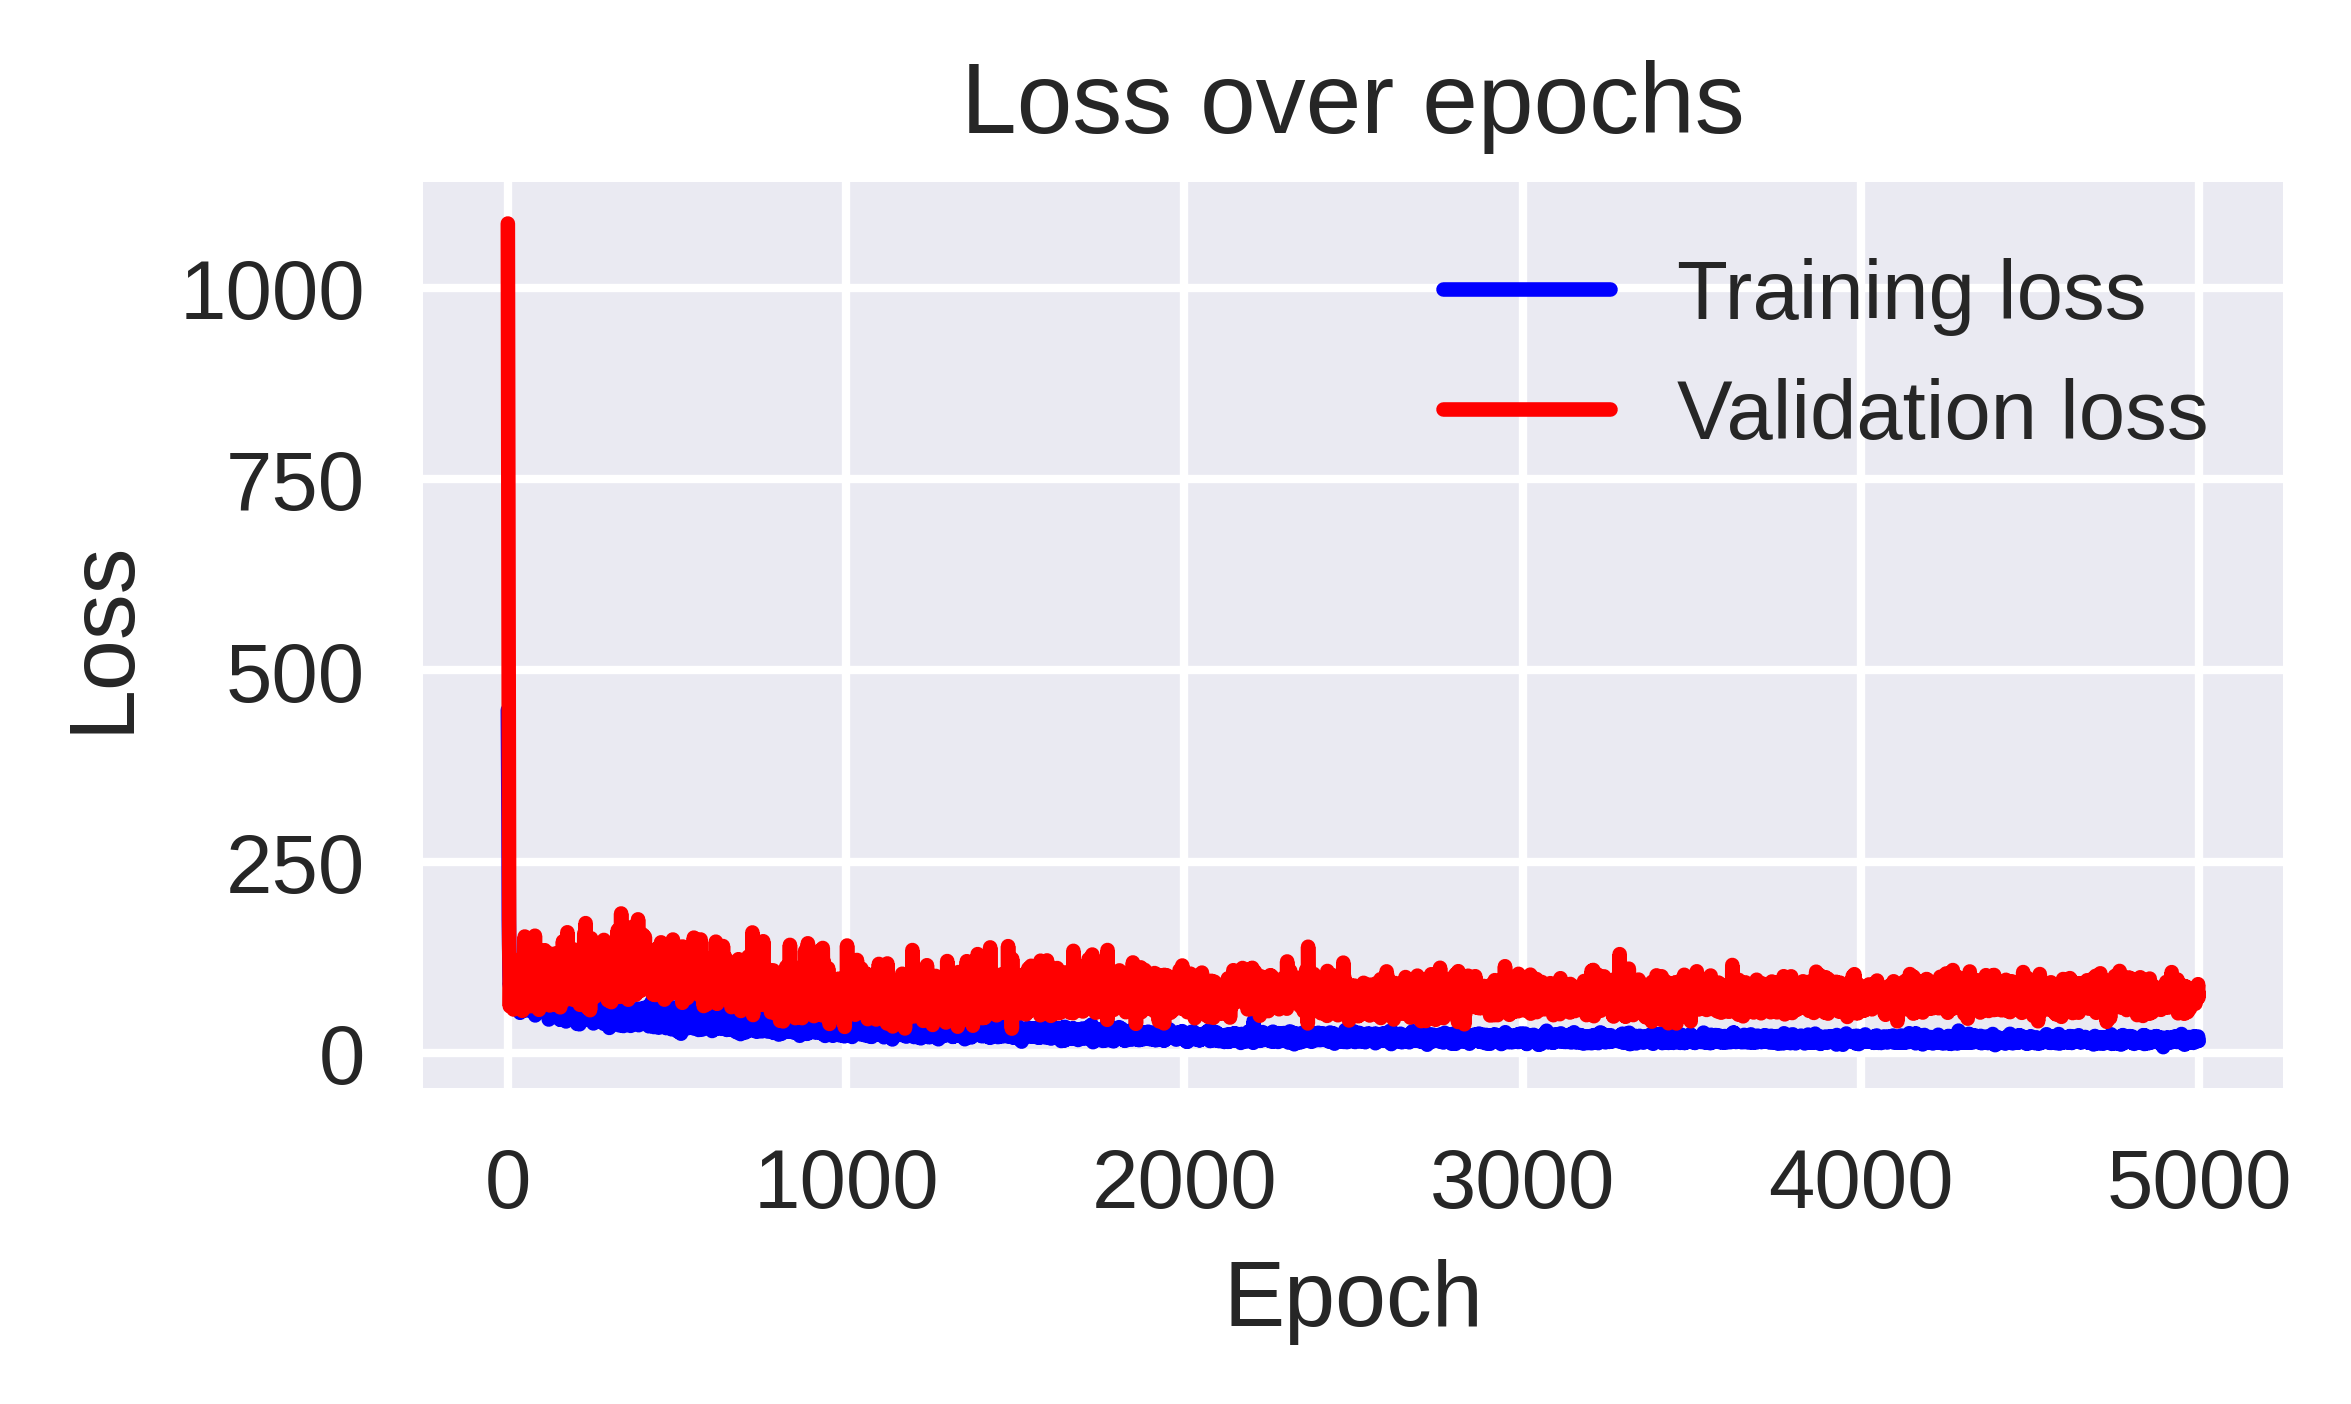

In [49]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title='Loss over epochs', 
       xlabel='Epoch', 
       ylabel='Loss')

ax.legend()

In [50]:
state_dict = torch.load('mlp_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [51]:
y_pred, y_valid= [], []

with torch.no_grad():

    model.eval()
    
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)    
        y_pred.append(model(x_val))
        y_valid.append(y_val)
        
y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

TypeError: ignored

In [52]:
mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print(f"MLP's forecast - MSE: {mlp_mse:.2f}, RMSE: {mlp_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label= 'True')
ax.plot(y_pred, color='red', label='Prediction')

ax.set(title="Multilayer Perceptron's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')

ax.legend()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)


ValueError: ignored

## 다변량 설정

**다중 입력 계열**

다중 시계열은 단일 시계열의 미래 가치를 예측하는 데 사용

**다중 병렬 계열**

다중 시계열은 다중 시계열의 미래 가치를 동시에 예측하는 데 사용

In [53]:
class MLP(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.linear2 = nn.Linear(16, 8)
        self.linear3 = nn.Linear(8, output_size)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x  

In [55]:
N_LAGS = 3
N_FUTURE = 2

torch.manual_seed(2022)

model = MLP(N_LAGS, N_FUTURE).to(device) 
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [57]:
PRINT_EVERY = 500
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        
        model.eval()
        
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint_2.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 44.35 	 Valid. loss: 56.14
<500> - Train. loss: 41.24 	 Valid. loss: 52.92
<1000> - Train. loss: 25.33 	 Valid. loss: 35.06
<1500> - Train. loss: 15.27 	 Valid. loss: 28.69
<2000> - Train. loss: 14.63 	 Valid. loss: 30.30
<2500> - Train. loss: 17.26 	 Valid. loss: 19.45
<3000> - Train. loss: 12.91 	 Valid. loss: 25.63
<3500> - Train. loss: 18.47 	 Valid. loss: 28.55
<4000> - Train. loss: 13.74 	 Valid. loss: 33.00
<4500> - Train. loss: 18.76 	 Valid. loss: 38.61
Lowest loss recorded in epoch: 3351


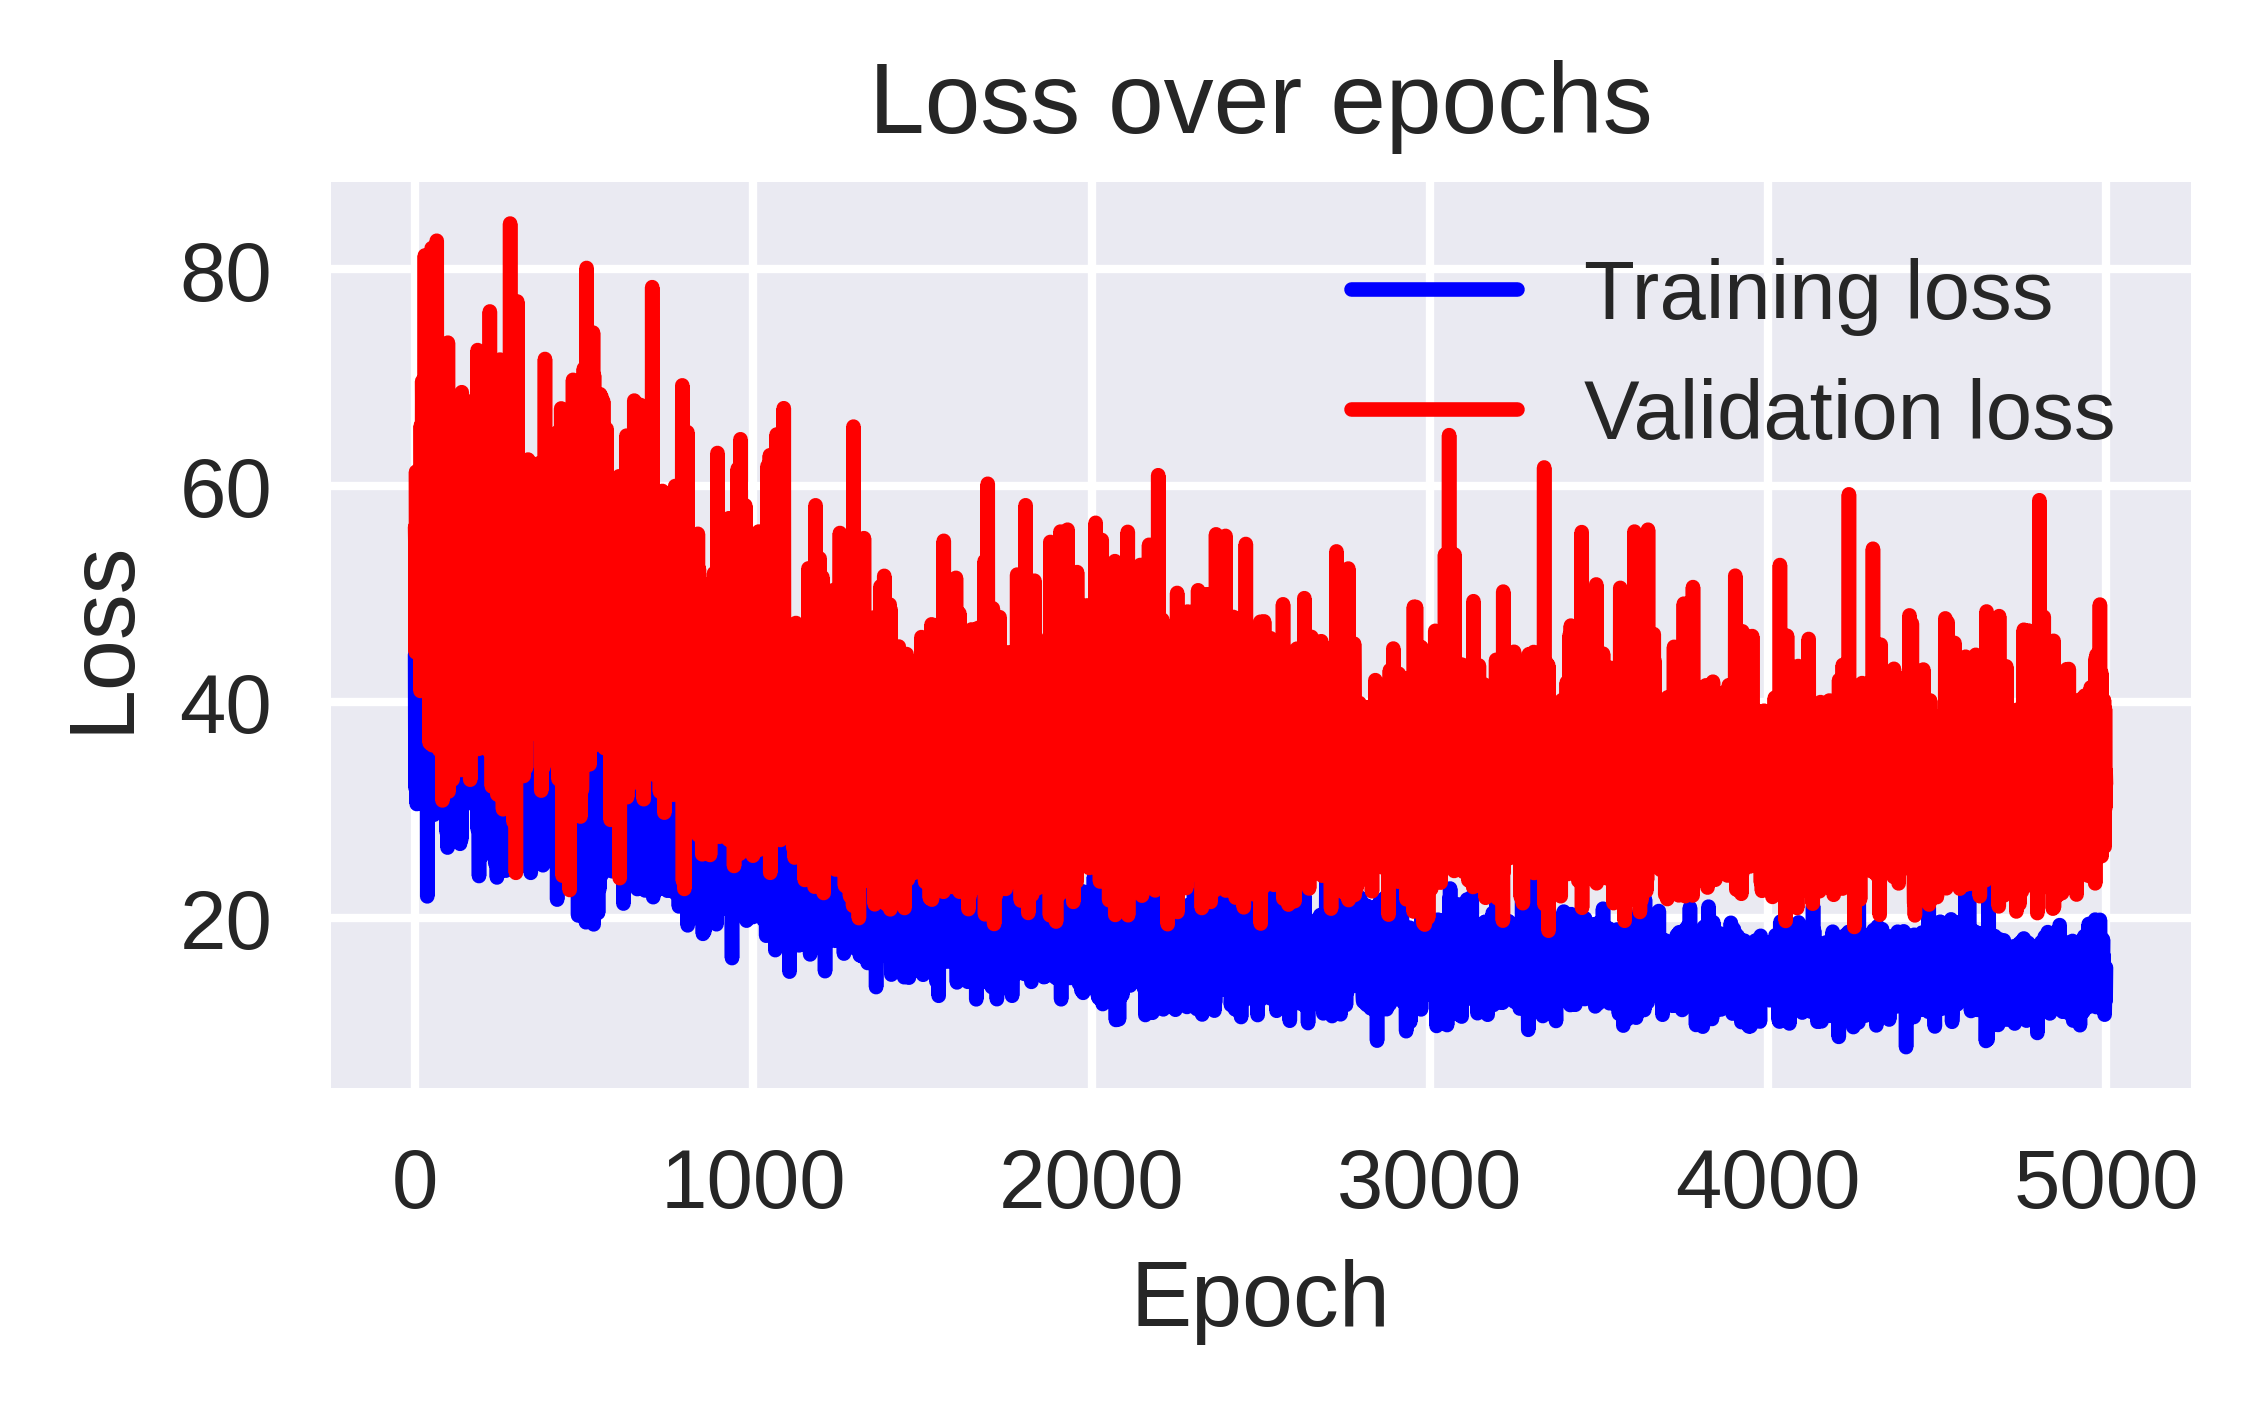

In [58]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend();

# 시계열 예측을 위한 컨볼루션 신경망

In [111]:
TICKER = 'INTC'
START_DATE = '2015-01-02'
END_DATE = '2019-12-31'
VALID_START = '2019-07-01'
N_LAGS = 12

# neural network 
BATCH_SIZE = 5
N_EPOCHS = 2000

In [112]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('W-MON').last()
valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Adj Close'].values

In [113]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-05,36.200001,36.450001,35.939999,35.950001,28.990009,32785000
2015-01-12,36.900002,37.000000,36.230000,36.599998,29.514162,29400800
2015-01-19,36.119999,36.660000,35.509998,36.450001,29.393198,62812200
2015-01-26,36.189999,36.299999,35.570000,35.810001,28.877113,30906800
2015-02-02,33.060001,33.750000,32.650002,33.650002,27.135284,38733800


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2015-01-05 to 2019-12-30
Freq: W-MON
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       261 non-null    float64
 1   High       261 non-null    float64
 2   Low        261 non-null    float64
 3   Close      261 non-null    float64
 4   Adj Close  261 non-null    float64
 5   Volume     261 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 22.4 KB


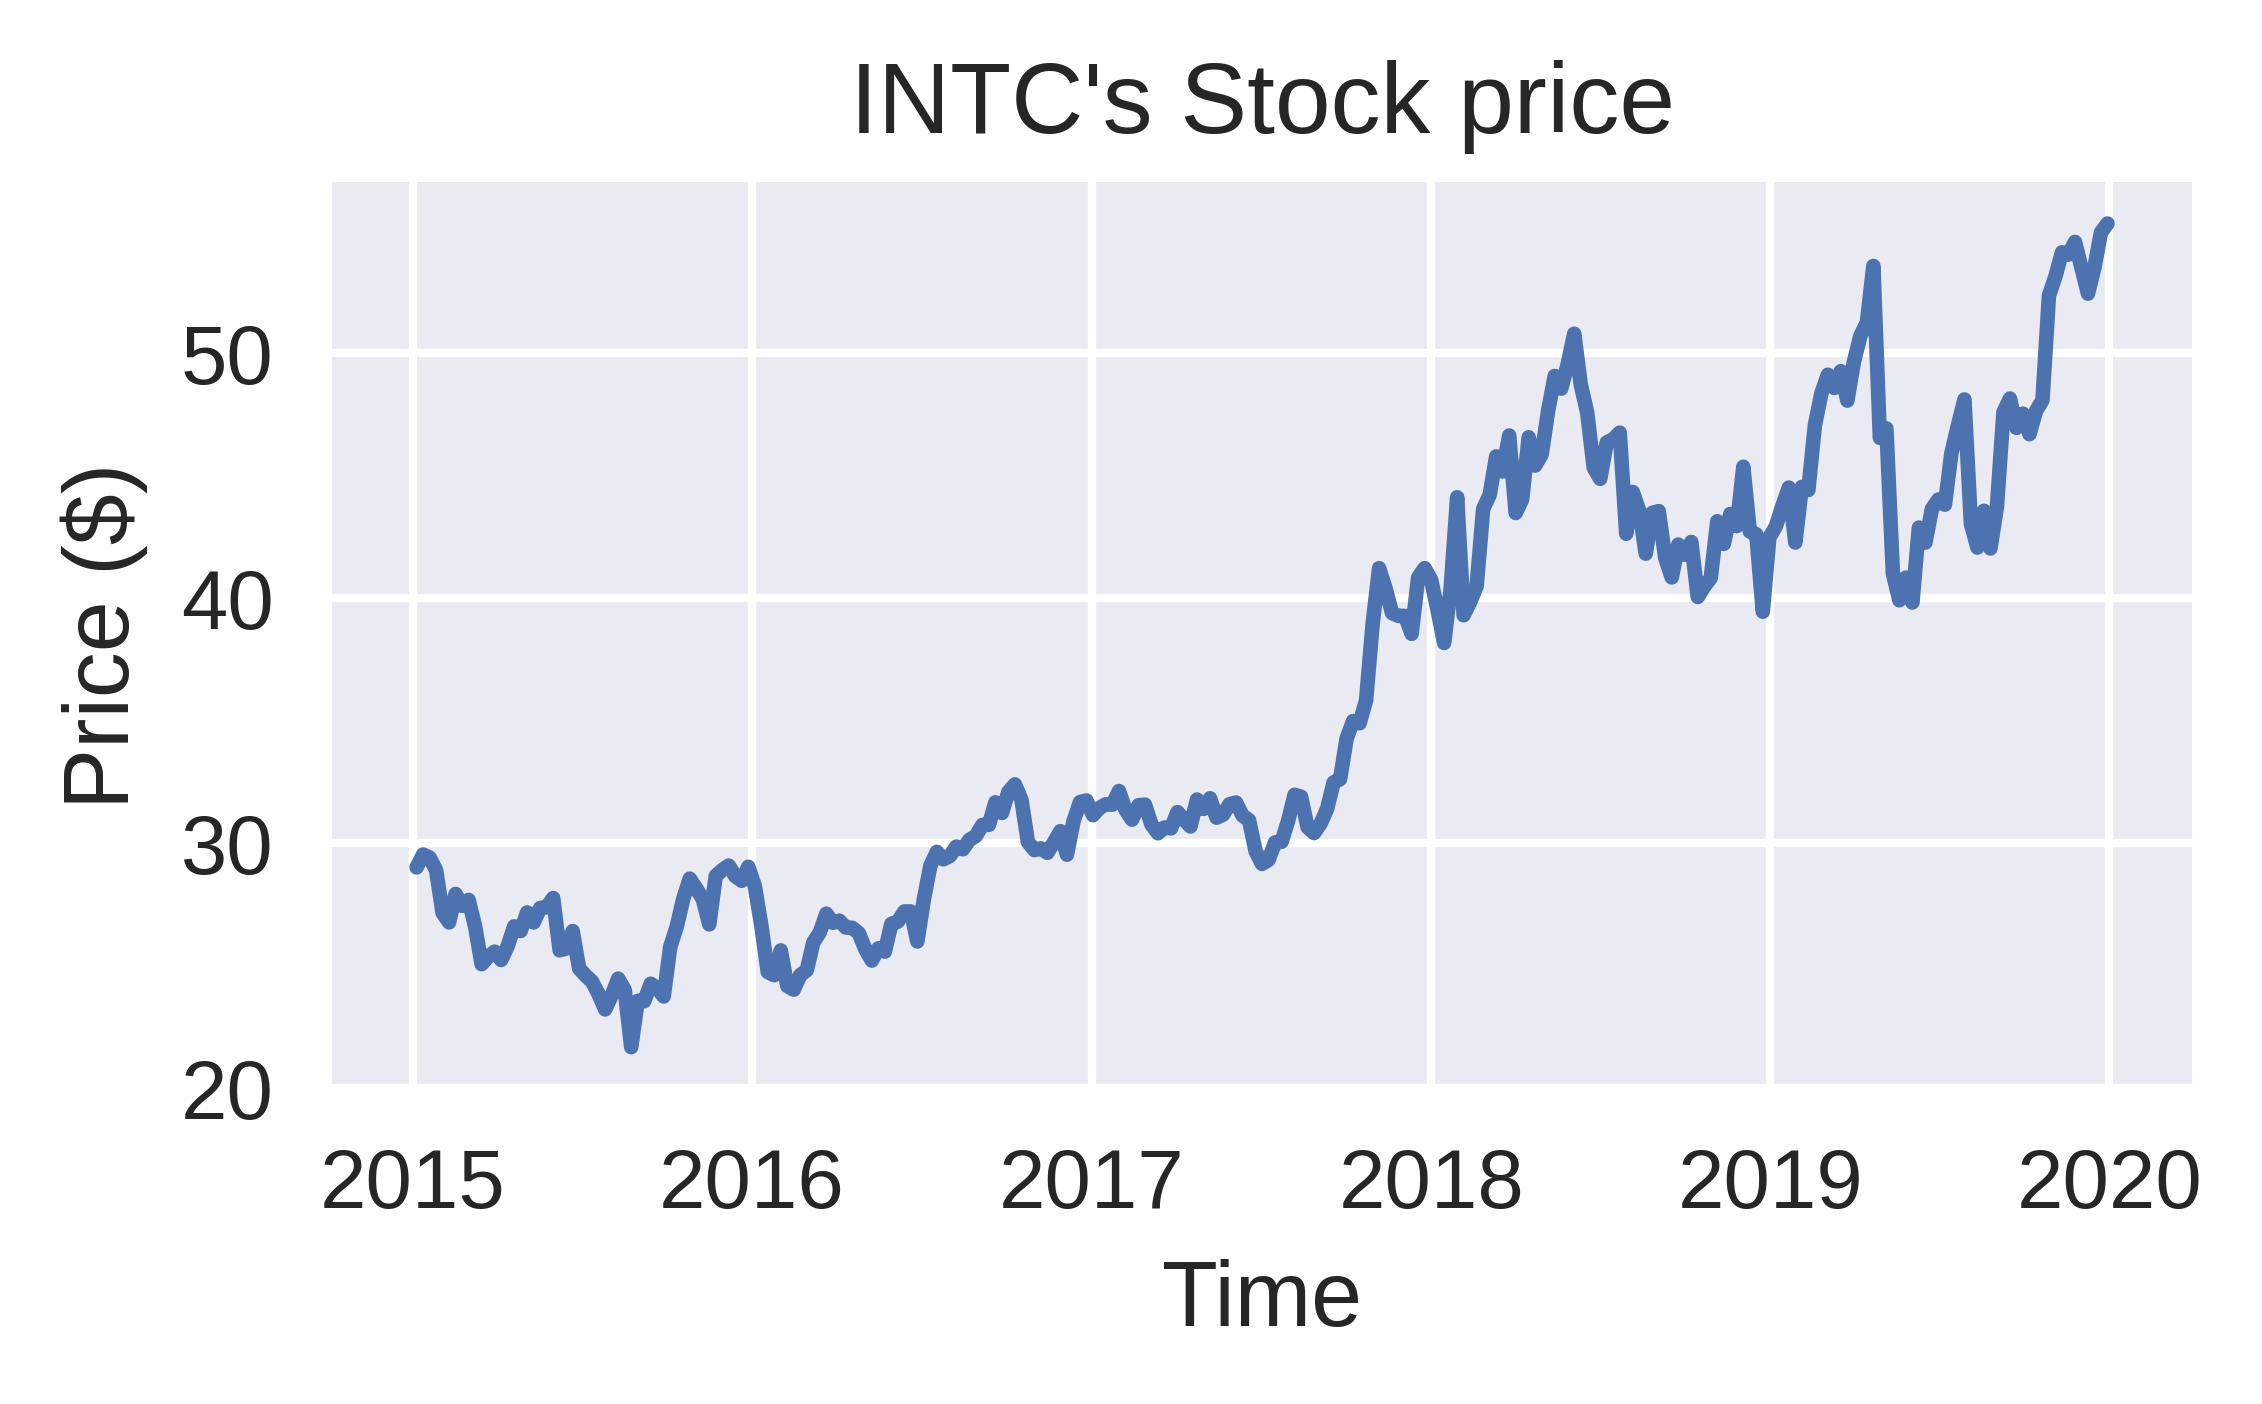

In [115]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

In [116]:
X, y = create_input_data(prices, N_LAGS)

In [117]:
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 3.17, RMSE: 1.78


In [118]:
custom_set_seed(2022)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

In [119]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 222 | validation: 27


In [120]:
class Flatten(nn.Module):

    def forward(self, x):
      
        return x.view(x.size()[0], -1)

model = nn.Sequential(OrderedDict([
    ('conv_1', nn.Conv1d(1, 32, 3, padding=1)),
    ('max_pool_1', nn.MaxPool1d(2)),
    ('relu_1', nn.ReLU()),
    ('flatten', Flatten()),
    ('fc_1', nn.Linear(192, 50)),
    ('relu_2', nn.ReLU()),
    ('dropout_1', nn.Dropout(0.4)),
    ('fc_2', nn.Linear(50, 1))
]))

print(model)

Sequential(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (flatten): Flatten()
  (fc_1): Linear(in_features=192, out_features=50, bias=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.4, inplace=False)
  (fc_2): Linear(in_features=50, out_features=1, bias=True)
)


In [121]:
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [122]:
PRINT_EVERY = 500
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        x_batch = x_batch.view(x_batch.shape[0], 1, N_LAGS)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(y_batch.shape[0], 1, 1)
        y_hat = model(x_batch).view(y_batch.shape[0], 1, 1)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
            y_val = y_val.to(device)
            y_val = y_val.view(y_val.shape[0], 1, 1)
            y_hat = model(x_val).view(y_val.shape[0], 1, 1)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './cnn_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.6f} \t Valid. loss: {epoch_loss_valid:.6f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 11.217886 	 Valid. loss: 2.592237
<500> - Train. loss: 5.739992 	 Valid. loss: 2.105186
<1000> - Train. loss: 3.692332 	 Valid. loss: 2.133878
<1500> - Train. loss: 2.994308 	 Valid. loss: 1.578863
Lowest loss recorded in epoch: 1765


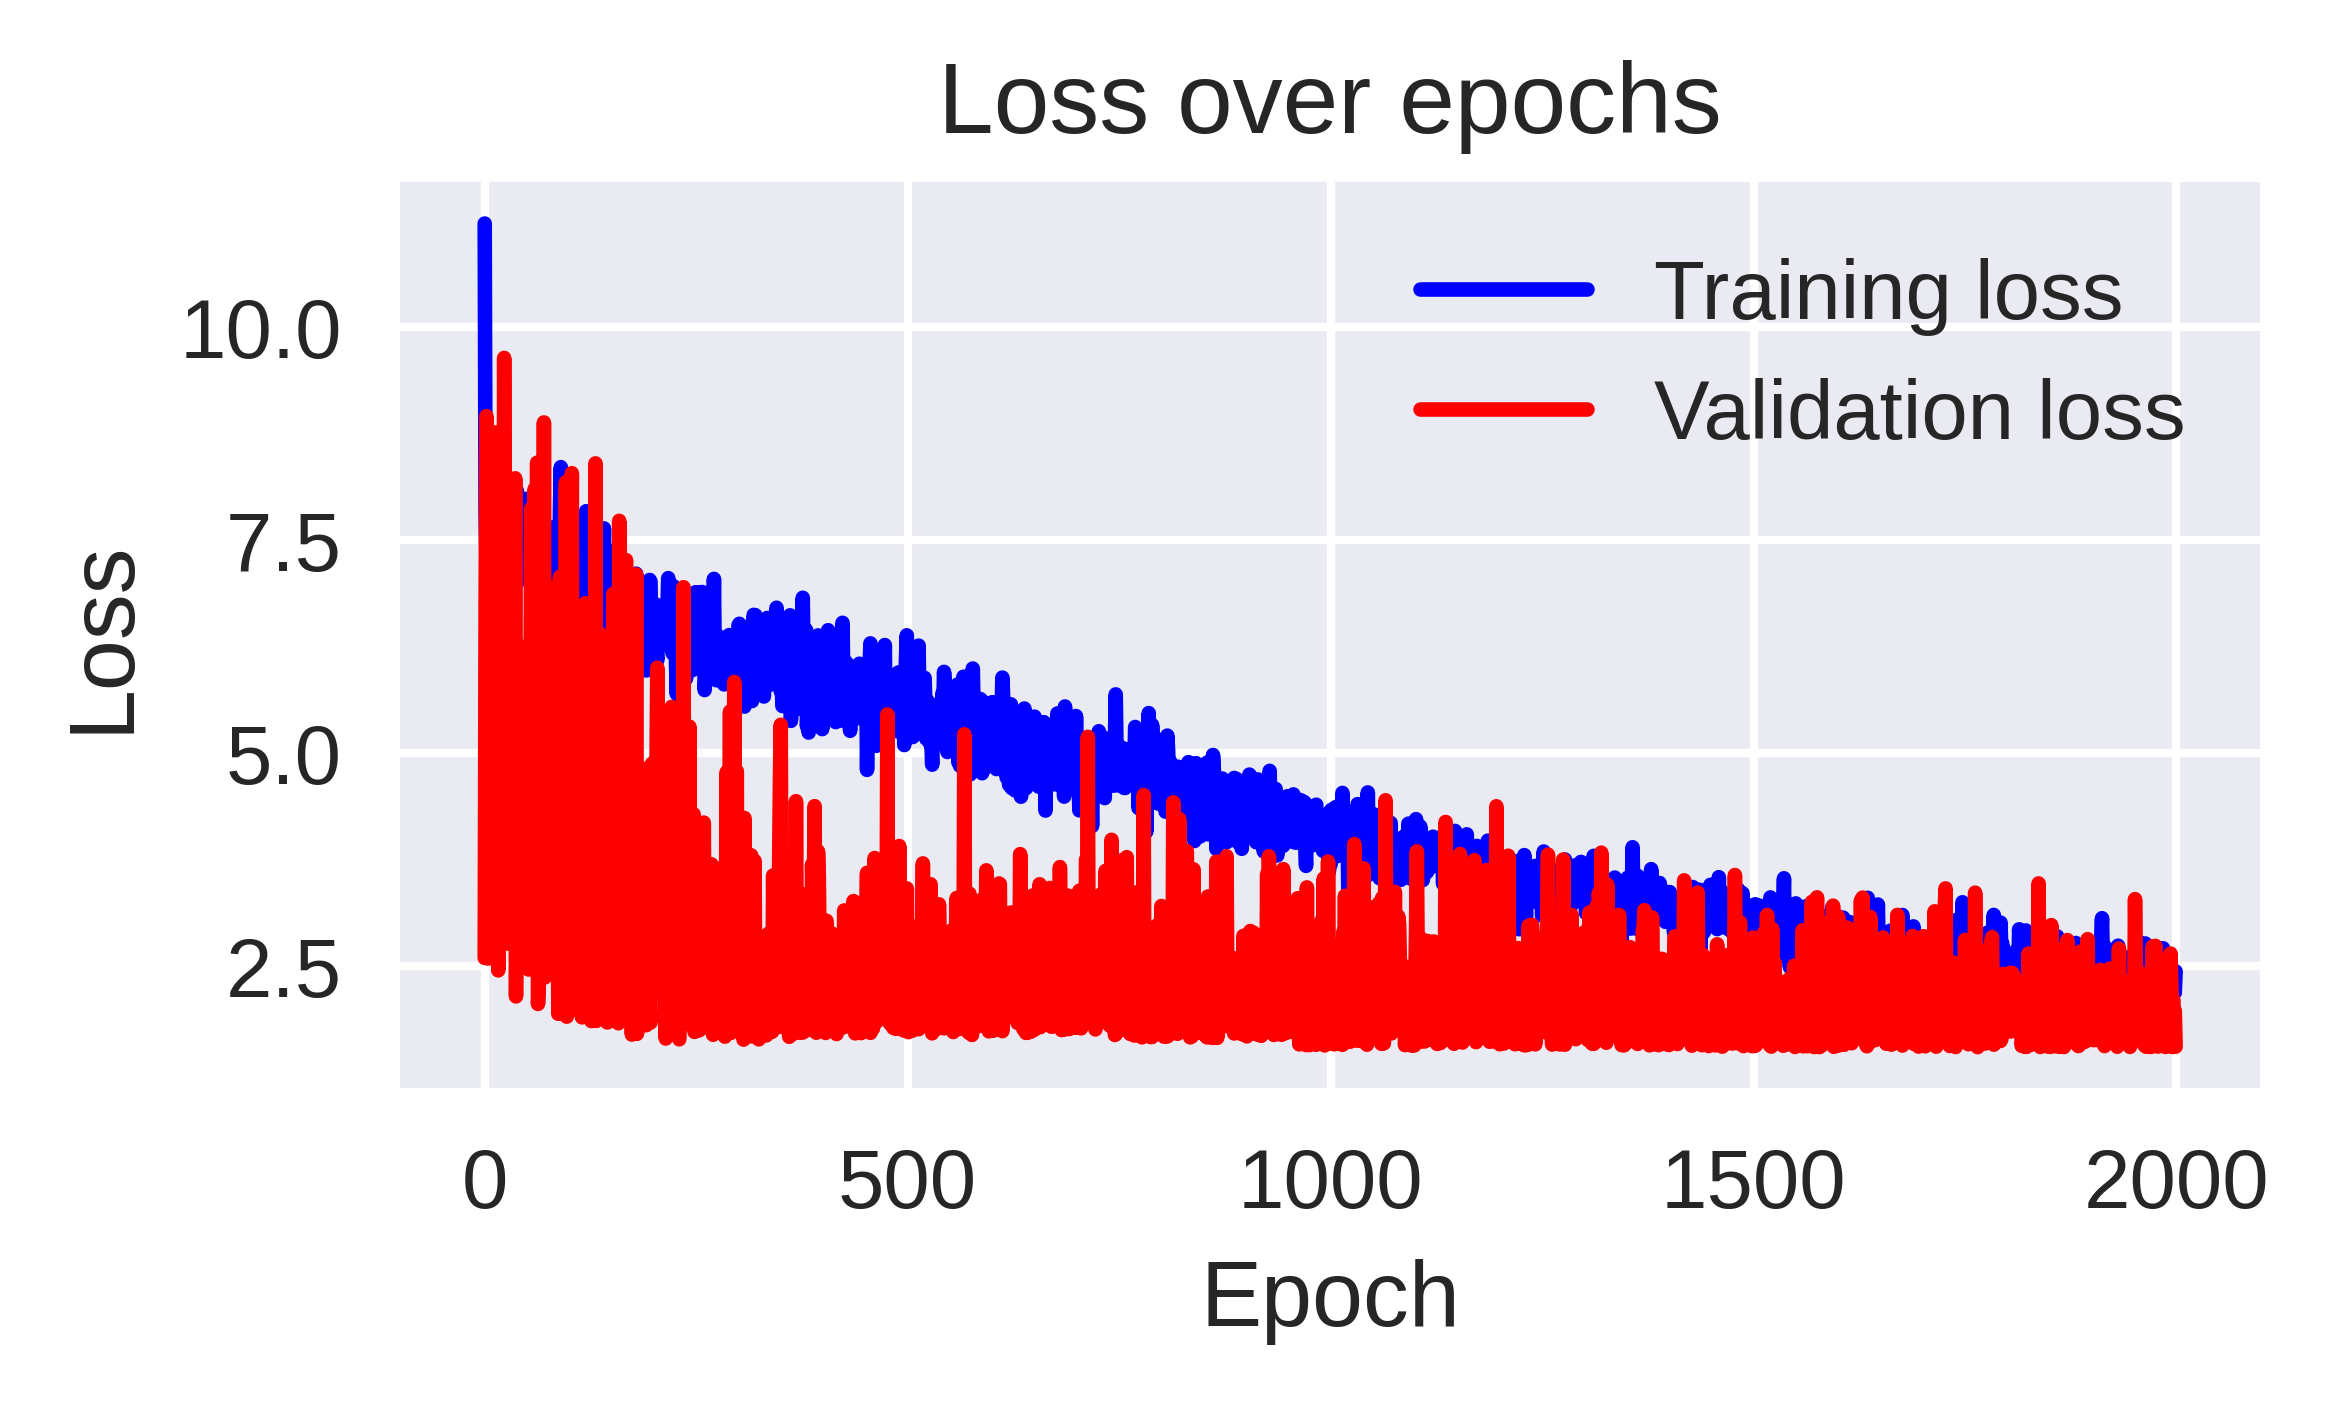

In [123]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')

ax.legend()

In [ ]:
state_dict = torch.load('cnn_checkpoint.pth')
model.load_state_dict(state_dict)

In [ ]:
y_pred, y_valid = [], []

with torch.no_grad():
    
    model.eval()
        
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
        y_pred.append(model(x_val))
        y_valid.append(y_val)
        
y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

In [ ]:
cnn_mse = mean_squared_error(y_valid, y_pred)
cnn_rmse = np.sqrt(cnn_mse)
print(f"CNN's forecast - MSE: {cnn_mse:.2f}, RMSE: {cnn_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='Prediction')


ax.set(title="CNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

plt.show()

# 시계열 예측을 위한 순환 신경망

In [124]:
TICKER = 'INTC'
START_DATE = '2010-01-02'
END_DATE = '2019-12-31'
VALID_START = '2019-07-01'
N_LAGS = 12

BATCH_SIZE = 16
N_EPOCHS = 100

In [125]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('W-MON').last()
valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Adj Close'].values.reshape(-1, 1)

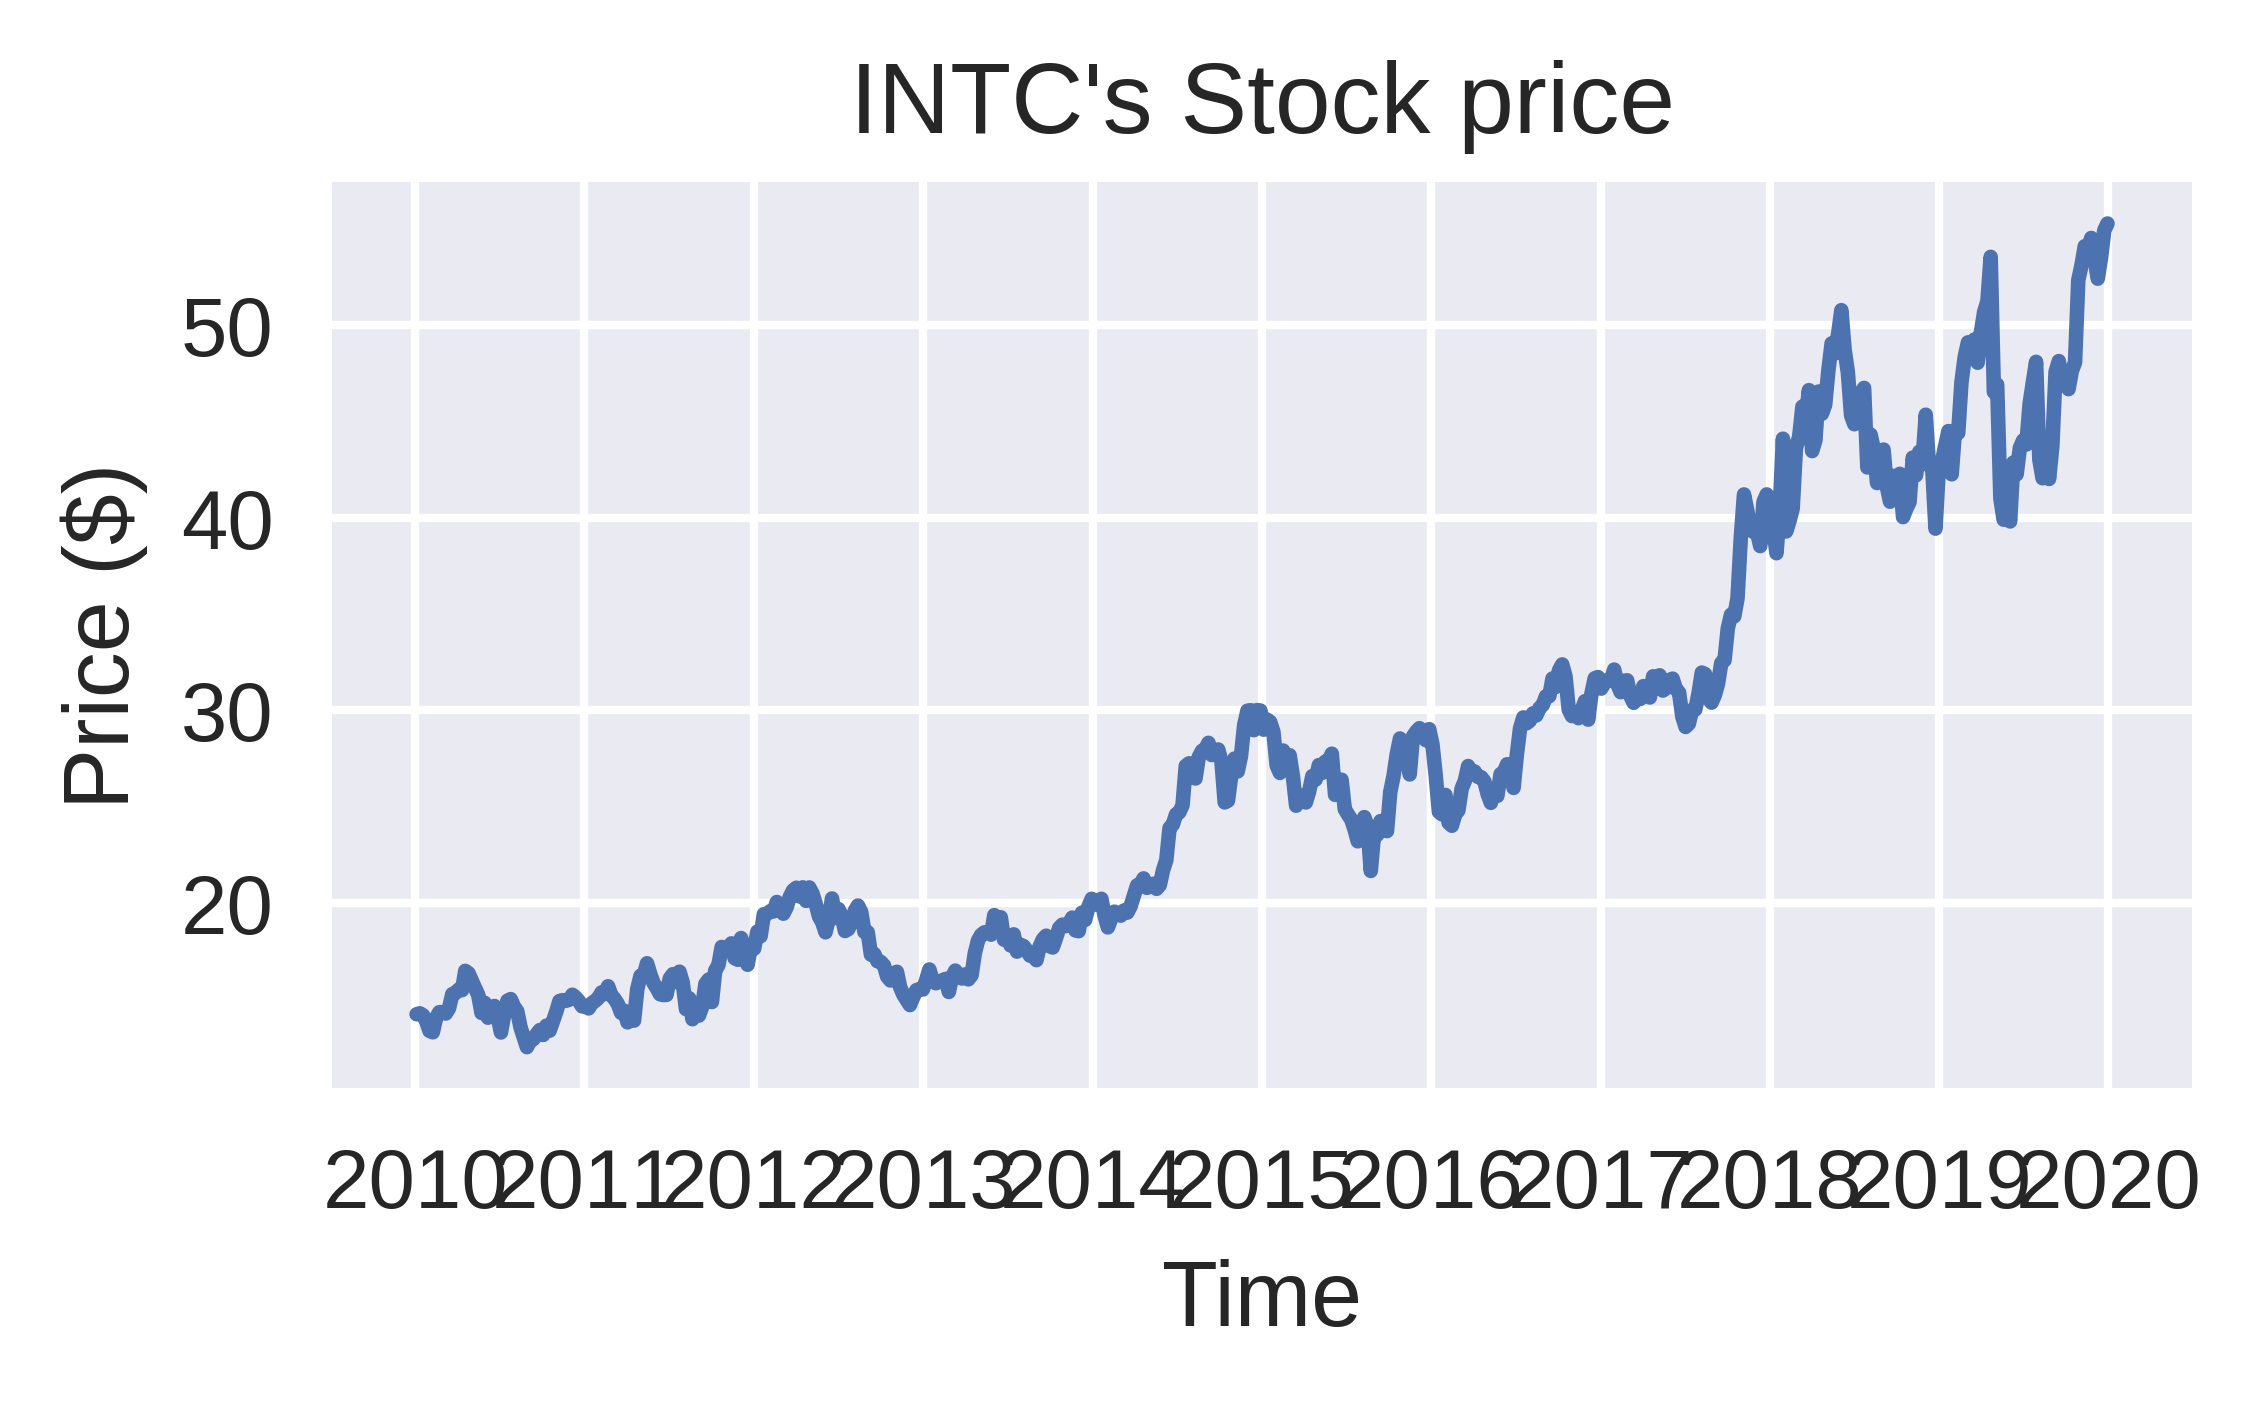

In [126]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

In [129]:
valid_ind = len(prices) - valid_size

minmax = MinMaxScaler(feature_range=(0, 1))

prices_train = prices[:valid_ind]
prices_valid = prices[valid_ind:]

minmax.fit(prices_train)

prices_train = minmax.transform(prices_train)
prices_valid = minmax.transform(prices_valid)

prices_scaled = np.concatenate((prices_train, 
                                prices_valid)).flatten()

In [130]:
X, y = create_input_data(prices_scaled, N_LAGS)

In [132]:
naive_pred = prices[len(prices)-valid_size-1:-1]
y_valid = prices[len(prices)-valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.4f}, RMSE: {naive_rmse:.4f}")

Naive forecast - MSE: 3.1713, RMSE: 1.7808


In [133]:
custom_set_seed(2022)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float().reshape(X.shape[0], 
                                               X.shape[1], 
                                               1)
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

In [134]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 483 | validation: 27


In [135]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, n_layers, output_size):

        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 
                          n_layers, batch_first=True,
                          nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):

        output, _ = self.rnn(x)
        output = self.fc(output[:,-1,:]) 
        
        return output

In [136]:
model = RNN(input_size=1, hidden_size=6, 
            n_layers=1, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [137]:
PRINT_EVERY = 10
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './rnn_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.4f} \t Valid. loss: {epoch_loss_valid:.4f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 0.2241 	 Valid. loss: 0.4834
<10> - Train. loss: 0.0606 	 Valid. loss: 0.0738
<20> - Train. loss: 0.0346 	 Valid. loss: 0.0694
<30> - Train. loss: 0.0345 	 Valid. loss: 0.0713
<40> - Train. loss: 0.0331 	 Valid. loss: 0.0778
<50> - Train. loss: 0.0320 	 Valid. loss: 0.0802
<60> - Train. loss: 0.0320 	 Valid. loss: 0.0693
<70> - Train. loss: 0.0313 	 Valid. loss: 0.0696
<80> - Train. loss: 0.0293 	 Valid. loss: 0.0696
<90> - Train. loss: 0.0295 	 Valid. loss: 0.0673
Lowest loss recorded in epoch: 89


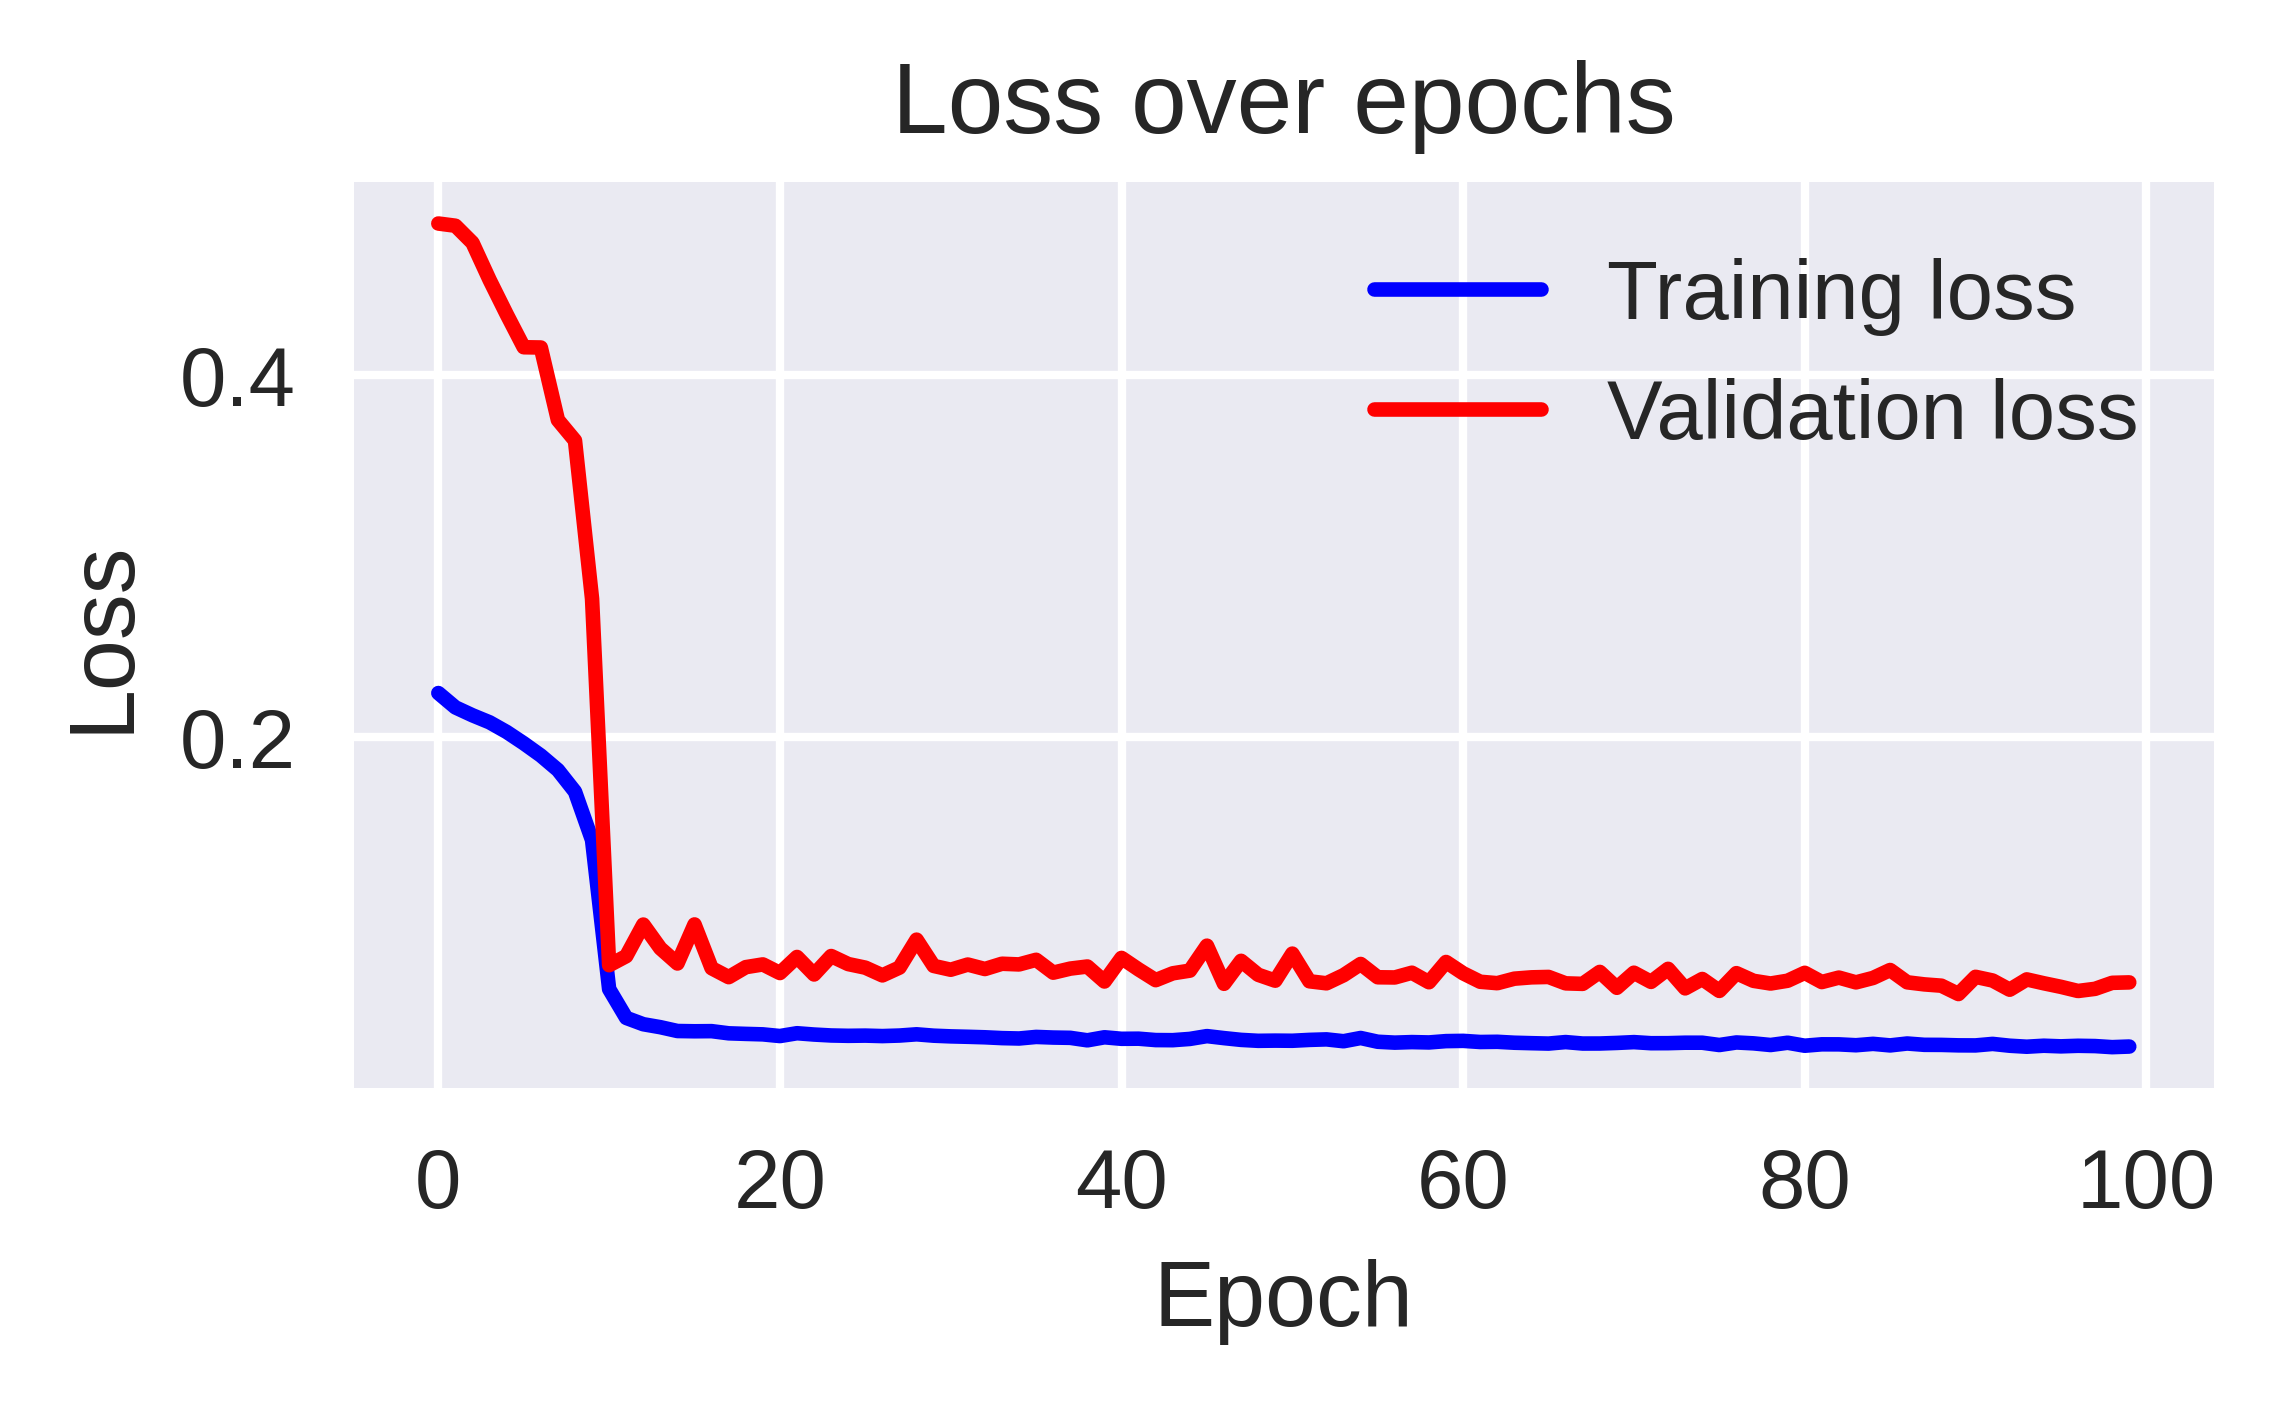

In [138]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')

ax.legend()

In [ ]:
state_dict = torch.load('rnn_checkpoint.pth')
model.load_state_dict(state_dict)

In [ ]:

y_pred = []

with torch.no_grad():
    
    model.eval()
    
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        y_hat = model(x_val)
        y_pred.append(y_hat)
        
y_pred = torch.cat(y_pred).numpy()
y_pred = minmax.inverse_transform(y_pred).flatten()

In [ ]:
rnn_mse = mean_squared_error(y_valid, y_pred)
rnn_rmse = np.sqrt(rnn_mse)
print(f"RNN's forecast - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='RNN')
ax.plot(naive_pred, color='green', label='Naïve')

ax.set(title="RNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')

ax.legend()